# Neural tagger fine-grained experiments analysis

In [1]:
from collections import defaultdict
import os
import pprint

from pymongo import MongoClient
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

%matplotlib inline

In [2]:
client = MongoClient(os.environ['SACRED_MONGO_URL'])
db = client[os.environ['SACRED_DB_NAME']]

## Best configuration

In [3]:
def get_data(run_criteria):
    if 'status' not in run_criteria:
        run_criteria['status'] = 'COMPLETED'

    data = defaultdict(list)
    for run in db.runs.find(run_criteria):
        data['run_id'].append(run['_id'])

        for conf in 'seed use_prefix use_suffix use_crf use_lstm window use_chars filter_width lr dropout'.split():
            data[conf].append(run['config'][conf])

        data['f1'].append(run['result'])
    return data

### Fold 1

In [4]:
db.runs.count({
    'experiment.name': 'id-pos-tagging-neural-fine',
    'meta.command': 'evaluate',
    'config.eval.which': 'dev',
    'config.corpus.dev': {'$regex': r'01.tsv$'},
})

296

In [5]:
run_criteria = {
    'experiment.name': 'id-pos-tagging-neural-fine',
    'meta.command': 'evaluate',
    'config.eval.which': 'dev',
    'config.corpus.dev': {'$regex': r'01.tsv$'},
}

In [6]:
df = pd.DataFrame(get_data(run_criteria))
len(df)

296

In [7]:
df.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window
0,0.634423,0.204581,5,0.069038,2671,34012962,False,False,True,False,False,0
1,0.132102,0.960026,3,0.009473,2672,571105080,False,False,False,True,False,2
2,0.258507,0.947309,4,0.018101,2673,837000391,False,False,False,True,True,0
3,0.224828,0.960910,5,0.006293,2674,480179107,False,False,False,True,False,4
4,0.582626,0.942911,5,0.012868,2675,377777196,False,False,False,True,False,0


In [8]:
df.iloc[df['f1'].idxmax()]

dropout           0.256525
f1                0.976301
filter_width             5
lr              0.00481577
run_id                2885
seed              38882601
use_chars             True
use_crf               True
use_lstm              True
use_prefix            True
use_suffix            True
window                   0
Name: 122, dtype: object

### Fold 2

TBD

### Fold 3

TBD

### Fold 4

TBD

### Fold 5

TBD

## Features analysis on fold 1

In [9]:
run_criteria = {
    'experiment.name': 'id-pos-tagging-neural-fine',
    'meta.command': 'evaluate',
    'config.eval.which': 'dev',
    'config.corpus.dev': {'$regex': r'01.tsv$'},
}

In [10]:
df = pd.DataFrame(get_data(run_criteria))
len(df)

296

In [11]:
df.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window
0,0.634423,0.204581,5,0.069038,2671,34012962,False,False,True,False,False,0
1,0.132102,0.960026,3,0.009473,2672,571105080,False,False,False,True,False,2
2,0.258507,0.947309,4,0.018101,2673,837000391,False,False,False,True,True,0
3,0.224828,0.960910,5,0.006293,2674,480179107,False,False,False,True,False,4
4,0.582626,0.942911,5,0.012868,2675,377777196,False,False,False,True,False,0


### Feedforward

In [12]:
df_ff = df[(~df.use_lstm) & (~df.use_crf)]
len(df_ff)

72

#### Binary features

##### use_prefix

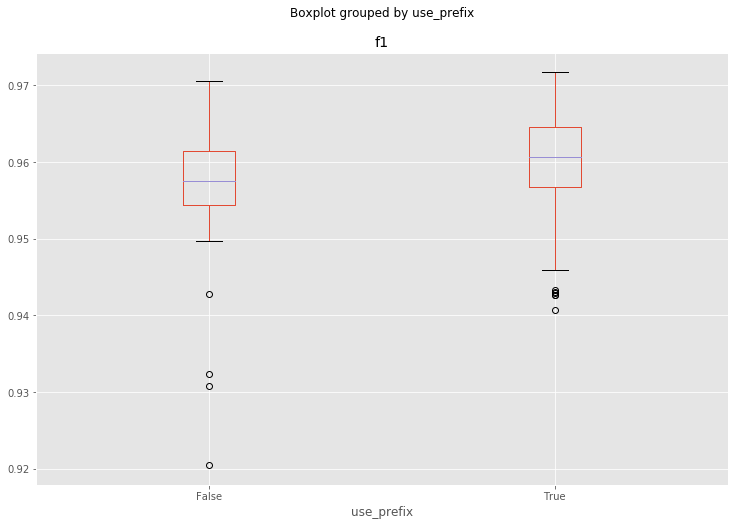

In [13]:
df_ff.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [14]:
ttest_ind(df_ff[df_ff.use_prefix]['f1'], df_ff[~df_ff.use_prefix]['f1'])

Ttest_indResult(statistic=1.7321557357824118, pvalue=0.08765031658430864)

The p-value is larger than 0.05, so we accept the null hypothesis: there does not seem a significant difference between using and not using prefixes. However, we conjecture that this is because of the character features. `use_prefix` might be significant when character features are not used. Let's see.

In [17]:
len(df_ff[~df_ff.use_chars])

41

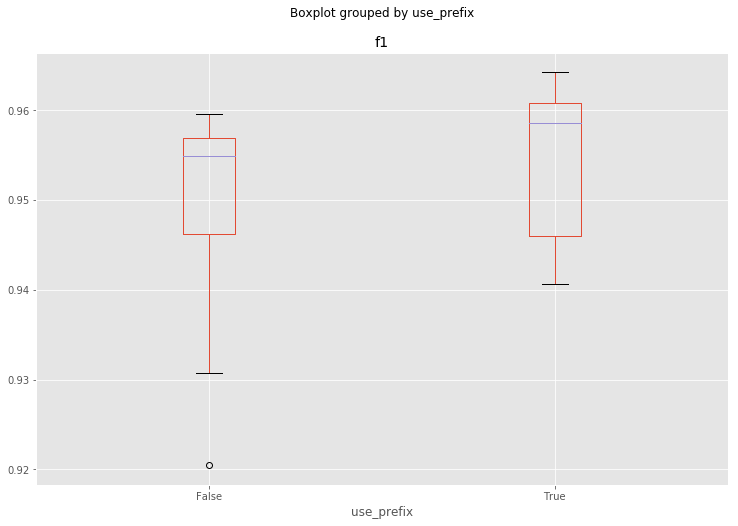

In [15]:
df_ff[~df_ff.use_chars].boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [16]:
ttest_ind(df_ff[(~df_ff.use_chars) & (df_ff.use_prefix)]['f1'], df_ff[(~df_ff.use_chars) & (~df_ff.use_prefix)]['f1'])

Ttest_indResult(statistic=1.4513627296489326, pvalue=0.15467593864286636)

The p-value is still high, so it seems we have to accept the null hypothesis that `use_prefix` is not really significant, even when no character features are used.

##### use_suffix

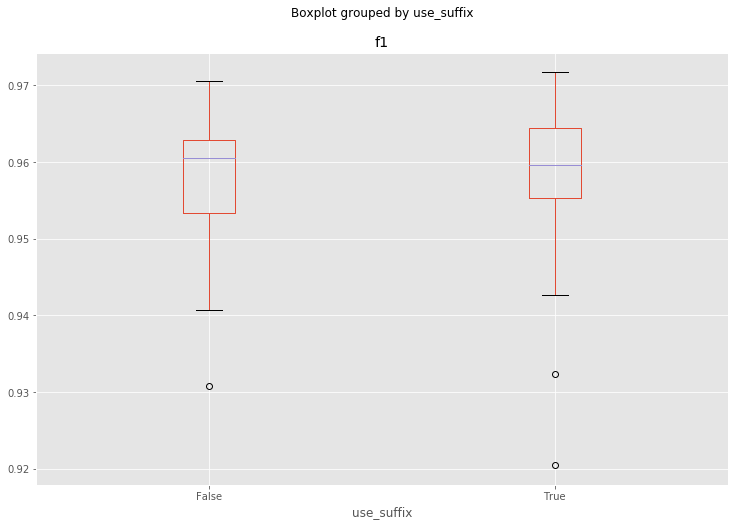

In [18]:
df_ff.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [19]:
ttest_ind(df_ff[df_ff.use_suffix]['f1'], df_ff[~df_ff.use_suffix]['f1'])

Ttest_indResult(statistic=0.27264557911568466, pvalue=0.7859283556747924)

The p-value is large. Accept null hypothesis. Let's see when characters are not used.

In [20]:
len(df_ff[~df_ff.use_chars])

41

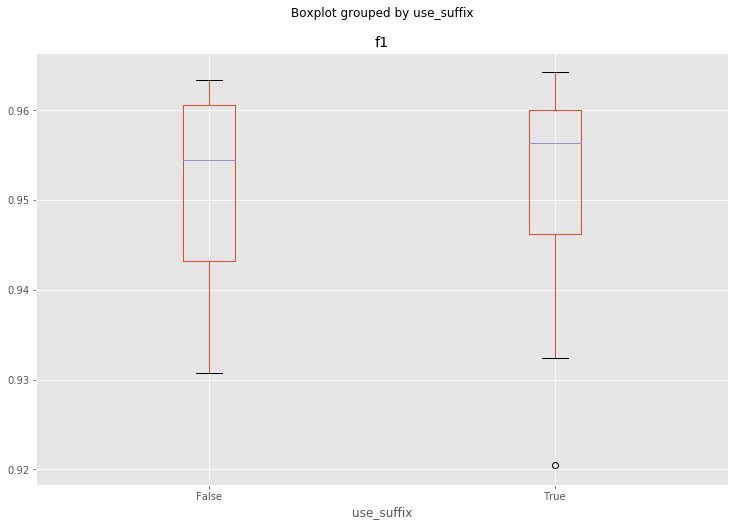

In [21]:
df_ff[~df_ff.use_chars].boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [22]:
ttest_ind(df_ff[(~df_ff.use_chars) & (df_ff.use_suffix)]['f1'], df_ff[(~df_ff.use_chars) & (~df_ff.use_suffix)]['f1'])

Ttest_indResult(statistic=0.2518142492876432, pvalue=0.8025069225845362)

The p-value is still large, so we accept the null hypothesis.

##### use_chars

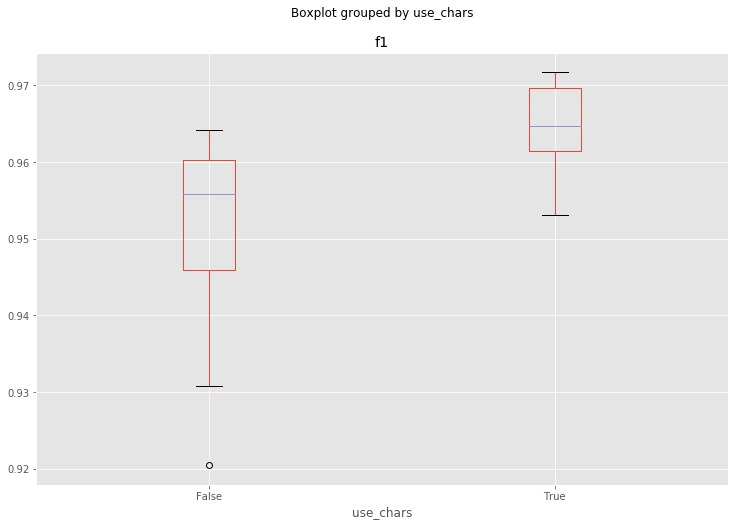

In [29]:
df_ff.boxplot(column='f1', by='use_chars', figsize=(12, 8))

It seems clear that `use_chars=True` is better than `use_chars=False`.

#### Multinomial variables

##### window

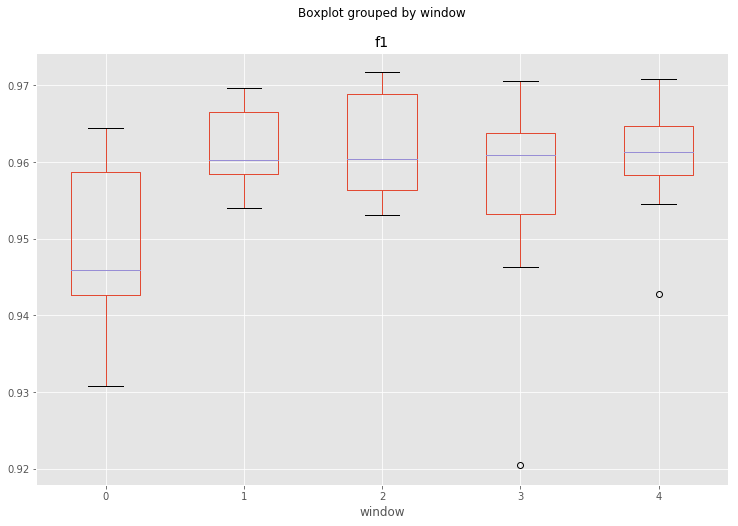

In [24]:
df_ff.boxplot(column='f1', by='window', figsize=(12, 8))

We see that it seems `window=0` yields lower F1 score in general, while the other values yield somewhat on par F1 score. Let's exclude `window=0` and perform a test to see if there's significant differences among the others.

In [25]:
samples = []
for window in range(1, 5):
    samples.append(df_ff[df_ff.window == window]['f1'])

In [26]:
f_oneway(*samples)

F_onewayResult(statistic=0.9407470444997383, pvalue=0.4278791187054434)

The p-value is very large, so we accept the null hypothesis.

##### filter_width

This config only makes sense when `use_chars=True`, so let's filter that.

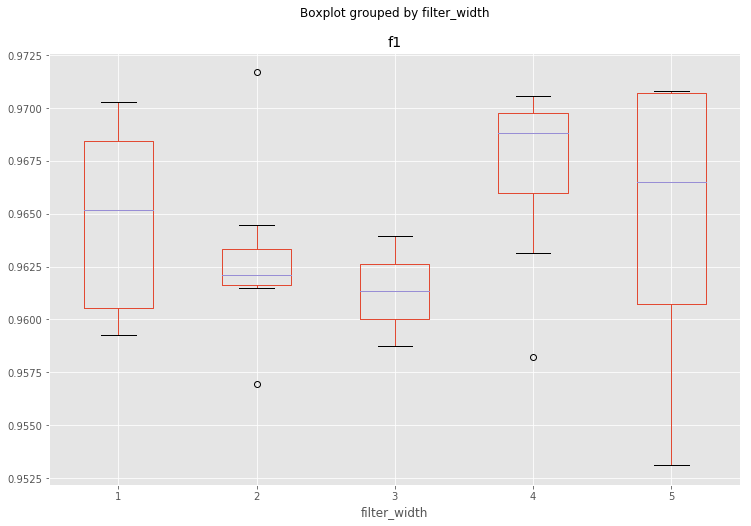

In [27]:
df_ff[df_ff.use_chars].boxplot(column='f1', by='filter_width', figsize=(12, 8))

From this plot, it seems `filter_width=4` yields the best F1 score in general. This is somewhat surprising because affixes in Indonesian usually have 2 or 3 characters, so we expect the best filter width would be 2 or 3 as well since it may capture affixes. However, this does not seem the case. The character embedding model might be capturing something else.

#### Continuous variables

##### lr

In [28]:
df_ff['log10_lr'] = np.log10(df_ff.lr)

/Users/kemal/.pyenv/versions/miniconda3-latest/envs/id-pos-tagging/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_ff.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window,log10_lr
1,0.132102,0.960026,3,0.009473,2672,571105080,False,False,False,True,False,2,-2.023496
2,0.258507,0.947309,4,0.018101,2673,837000391,False,False,False,True,True,0,-1.742296
3,0.224828,0.960910,5,0.006293,2674,480179107,False,False,False,True,False,4,-2.201169
4,0.582626,0.942911,5,0.012868,2675,377777196,False,False,False,True,False,0,-1.890475
6,0.214168,0.961152,1,0.039620,2677,989740547,False,False,False,True,True,3,-1.402091


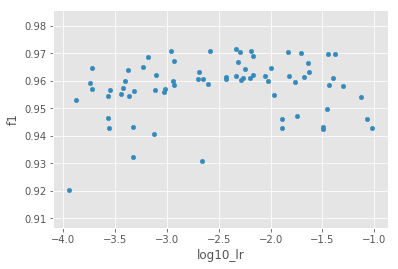

In [30]:
df_ff.plot.scatter(x='log10_lr', y='f1')

There does not seem any linear trend between the learning rate and F1 score. However, from the plot we see that when `log10_lr` is between -2.5 and -2, the F1 score never goes much lower than 0.96.

##### dropout

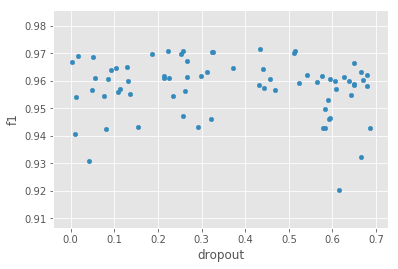

In [31]:
df_ff.plot.scatter(x='dropout', y='f1')

There does not seem a clear trend. However, when dropout is between 0.35 and 0.55, the F1 score never goes much lower than 0.96.

#### Conclusion

- Prefixes are not significant
- Suffixes are not significant
- Characters are significant
- Window size greater than 0 are all comparable
- Best filter width is 4
- Best range for the power of learning rate is -2.5 to -2
- Best range for dropout is between 0.35 and 0.55.

### Feedforward + CRF

In [32]:
df_ff_crf = df[(~df.use_lstm) & (df.use_crf)]
len(df_ff_crf)

86

#### Binary features

##### use_prefix

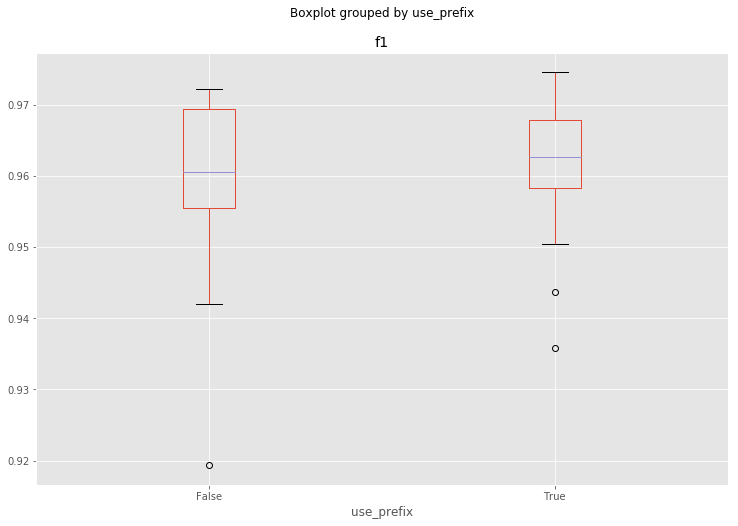

In [33]:
df_ff_crf.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [34]:
ttest_ind(df_ff_crf[df_ff_crf.use_prefix]['f1'], df_ff_crf[~df_ff_crf.use_prefix]['f1'])

Ttest_indResult(statistic=1.108218124633611, pvalue=0.27093070382047646)

The p-value is large, so we accept the null hypothesis. However, let's see if `use_chars` is turned off.

In [35]:
len(df_ff_crf[~df_ff_crf.use_chars])

48

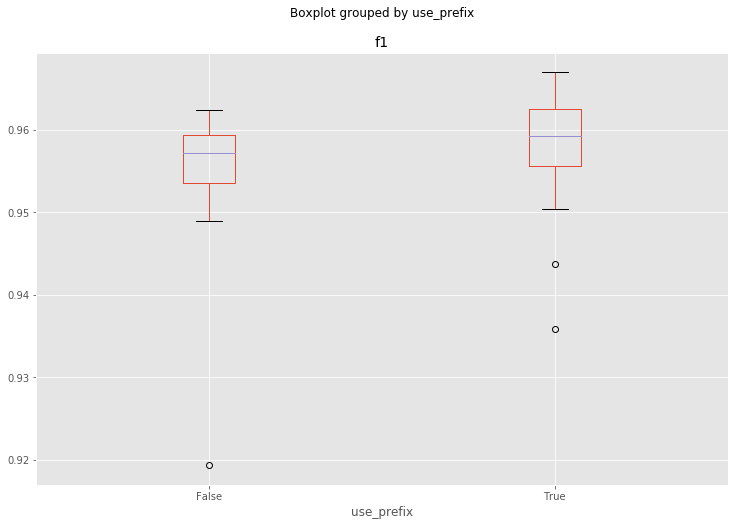

In [36]:
df_ff_crf[~df_ff_crf.use_chars].boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [37]:
ttest_ind(df_ff_crf[(~df_ff_crf.use_chars) & (df_ff_crf.use_prefix)]['f1'],
          df_ff_crf[(~df_ff_crf.use_chars) & (~df_ff_crf.use_prefix)]['f1'])

Ttest_indResult(statistic=1.3225912485261841, pvalue=0.19250945615228)

The p-value is still large, so we accept the null hypothesis. It seems that prefixes are not significant although characters are not used.

##### use_suffix

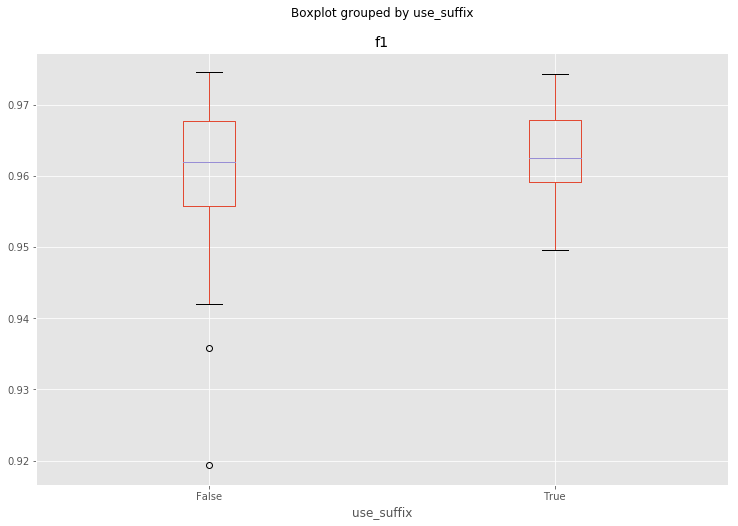

In [38]:
df_ff_crf.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [39]:
ttest_ind(df_ff_crf[df_ff_crf.use_suffix]['f1'], df_ff_crf[~df_ff_crf.use_suffix]['f1'])

Ttest_indResult(statistic=1.4729588766878576, pvalue=0.14449947415424264)

Again, the p-value is large. Accept null hypothesis. Let's see when characters aren't used.

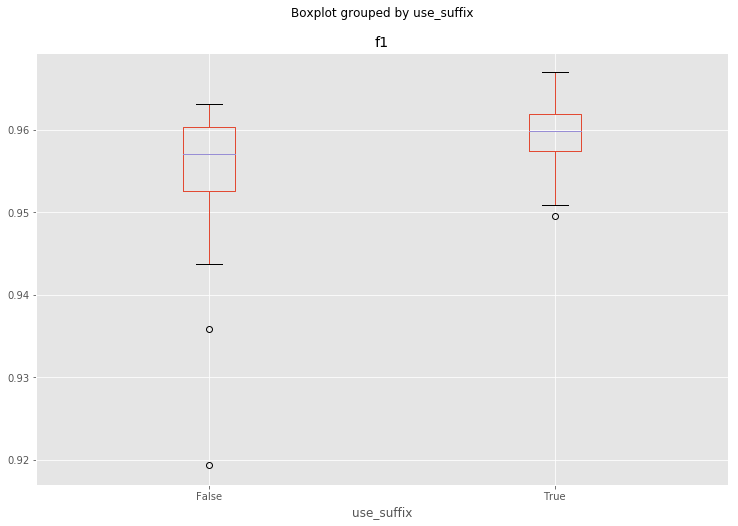

In [40]:
df_ff_crf[~df_ff_crf.use_chars].boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [41]:
ttest_ind(df_ff_crf[(~df_ff_crf.use_chars) & (df_ff_crf.use_suffix)]['f1'],
          df_ff_crf[(~df_ff_crf.use_chars) & (~df_ff_crf.use_suffix)]['f1'])

Ttest_indResult(statistic=2.07541758855775, pvalue=0.043566534588890225)

The p-value is small (less than 0.05), so we reject the null hypothesis. Thus, it seems suffixes are significant for the feedforward with CRF layer model when characters are not used.

##### use_chars

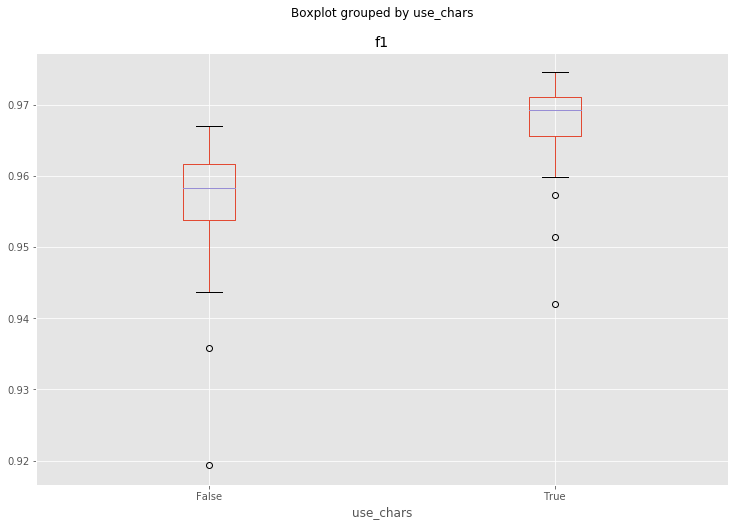

In [42]:
df_ff_crf.boxplot(column='f1', by='use_chars', figsize=(12, 8))

It seems `use_chars=True` is significantly better than `False`.

#### Multinomial variables

##### window

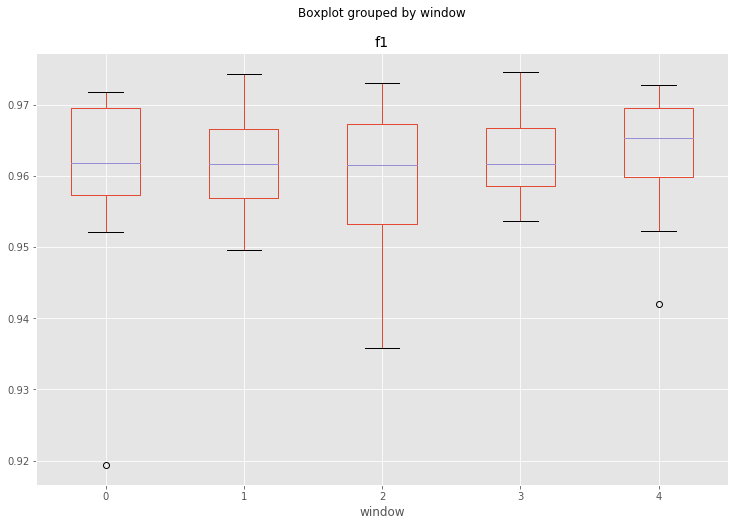

In [43]:
df_ff_crf.boxplot(column='f1', by='window', figsize=(12, 8))

There does not seem any significant difference among different values for `window`.

##### filter_width

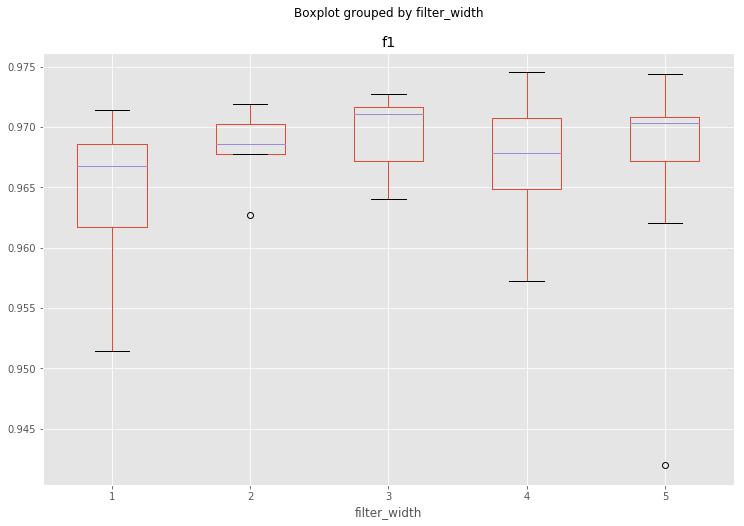

In [44]:
df_ff_crf[df_ff_crf.use_chars].boxplot(column='f1', by='filter_width', figsize=(12, 8))

From the plot, it seems `filter_width=2` or `filter_width=3` works best. This matches our intuition that character features should be able to capture affixes, which in Indonesian usually consists of 2 or 3 characters.

#### Continuous variables

##### lr

In [45]:
df_ff_crf2 = df_ff_crf.copy()

In [46]:
df_ff_crf2['log10_lr'] = np.log10(df_ff_crf2['lr'])

In [47]:
df_ff_crf2.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window,log10_lr
17,0.247807,0.962183,1,0.027555,2688,69454154,False,True,False,True,False,4,-1.559795
24,0.368162,0.958497,2,0.019758,2695,669103111,False,True,False,False,False,3,-1.704251
26,0.517044,0.952728,5,0.076833,2697,302193560,False,True,False,False,False,1,-1.114450
32,0.157434,0.958784,5,0.000348,2703,146059897,False,True,False,True,False,3,-3.458432
34,0.075055,0.952112,1,0.000139,2705,129614248,False,True,False,True,False,0,-3.856884


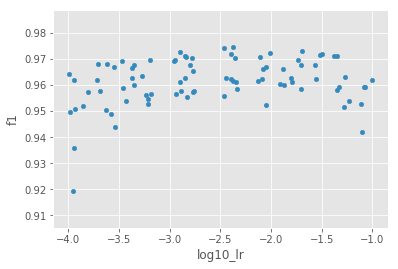

In [48]:
df_ff_crf2.plot.scatter(x='log10_lr', y='f1')

The plot seems to have an upside-down U trend, although not very clearly. It seems the best range for `log10_lr` is between -3 and -1.5.

##### dropout

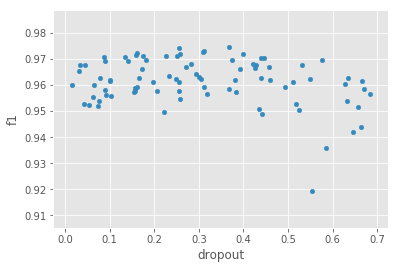

In [49]:
df_ff_crf.plot.scatter(x='dropout', y='f1')

It seems the best range for dropout is between 0.25 and 0.4.

#### Conclusion

- Prefixes are not significant
- Suffixes are significant only when characters are not used
- Characters are significant
- Any value for window achieves on par F1 score
- Filter width of 2 or 3 is best
- Best range for the power of learning rate is -3 ad -1.5
- Best range for dropout is 0.25 to 0.4

### LSTM

In [50]:
df_lstm = df[(df.use_lstm) & (~df.use_crf)]

In [51]:
df_lstm.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window
0,0.634423,0.204581,5,0.069038,2671,34012962,False,False,True,False,False,0
5,0.304057,0.960915,5,0.019847,2676,752276329,False,False,True,False,False,0
7,0.082773,0.968059,3,0.007260,2678,811399240,False,False,True,True,True,0
10,0.116364,0.965639,3,0.009684,2681,799135189,False,False,True,False,True,0
11,0.349528,0.967218,4,0.014770,2682,857452985,False,False,True,True,True,0


#### Binary variables

##### use_prefix

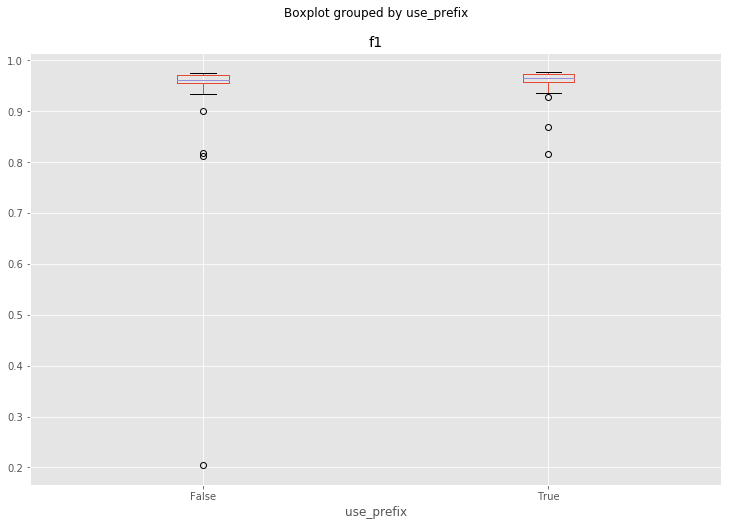

In [52]:
df_lstm.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

There are outliers that make the plot squeezed. Let's remove those and plot again.

In [53]:
df_lstm = df_lstm[df_lstm.f1 > 0.9]
len(df_lstm)

72

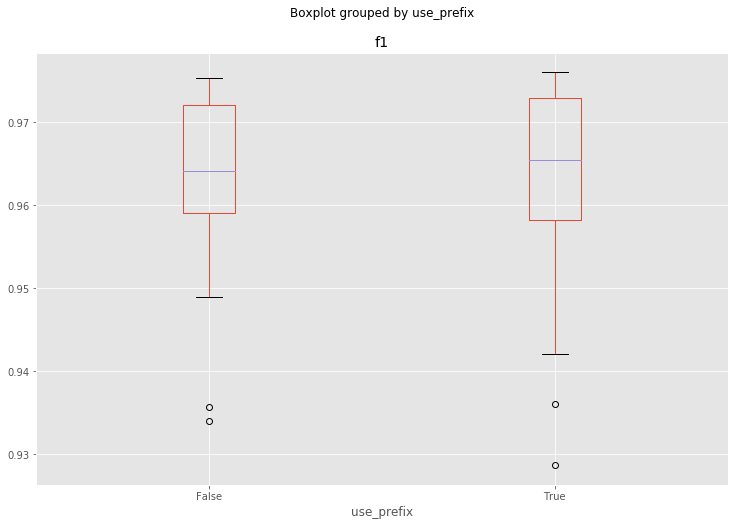

In [54]:
df_lstm.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [55]:
ttest_ind(df_lstm[df_lstm.use_prefix]['f1'], df_lstm[~df_lstm.use_prefix]['f1'])

Ttest_indResult(statistic=0.29197176741220354, pvalue=0.7711717829734396)

The p-value is high, so we accept null hypothesis. Let's see if characters are not used.

In [56]:
len(df_lstm[~df_lstm.use_chars])

37

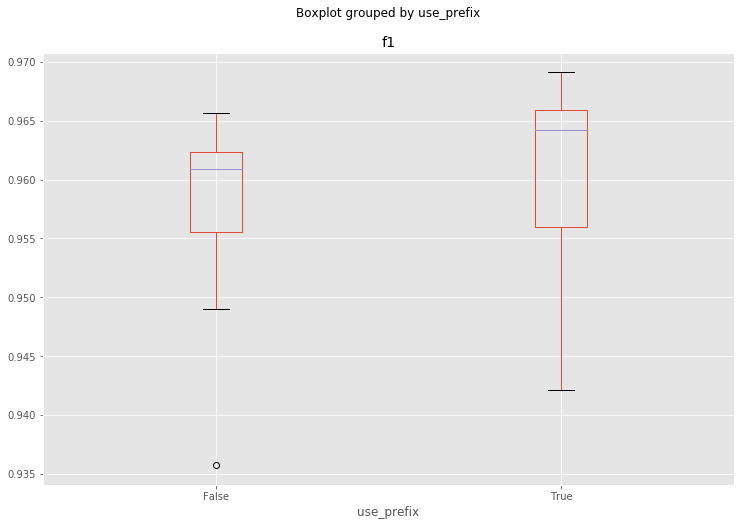

In [57]:
df_lstm[~df_lstm.use_chars].boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [58]:
ttest_ind(df_lstm[(~df_lstm.use_chars) & (df_lstm.use_prefix)]['f1'],
          df_lstm[(~df_lstm.use_chars) & (~df_lstm.use_prefix)]['f1'])

Ttest_indResult(statistic=1.0670099499863603, pvalue=0.29327232719925583)

The p-value is large, so we accept the null hypothesis.

##### use_suffix

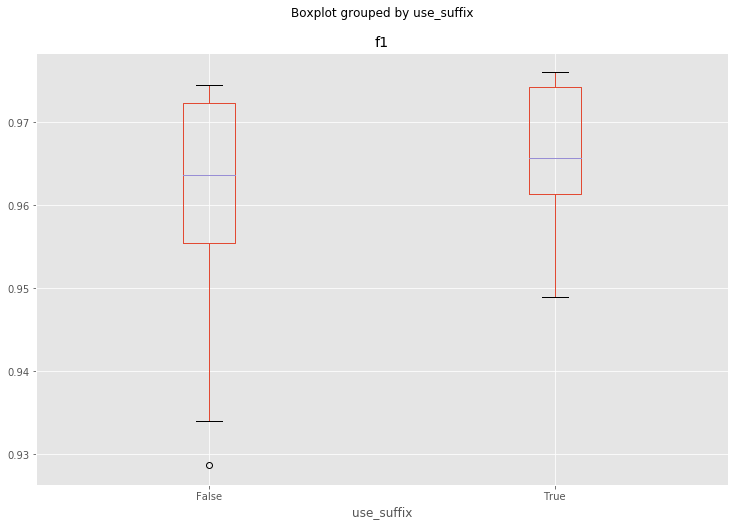

In [59]:
df_lstm.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [60]:
ttest_ind(df_lstm[df_lstm.use_suffix]['f1'], df_lstm[~df_lstm.use_suffix]['f1'])

Ttest_indResult(statistic=1.981218370746986, pvalue=0.05149609388728235)

The p-value is still higher than 0.05, but close. Accept null hypothesis. Let's see when characters are not used.

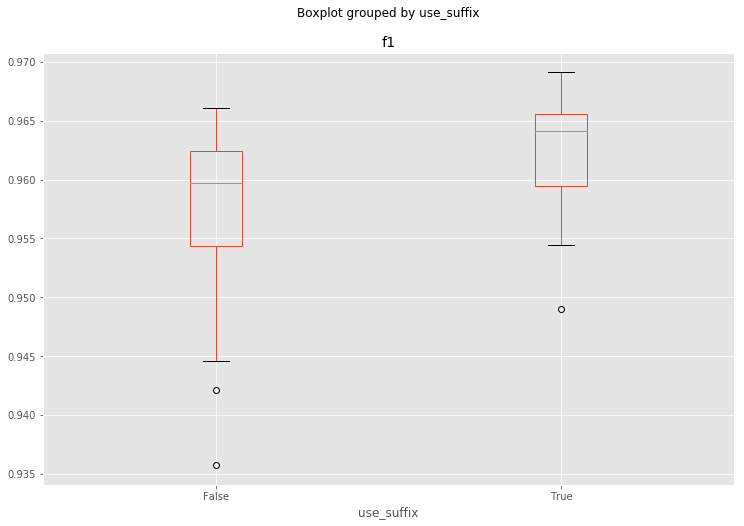

In [61]:
df_lstm[~df_lstm.use_chars].boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [62]:
ttest_ind(df_lstm[(~df_lstm.use_chars) & (df_lstm.use_suffix)]['f1'],
          df_lstm[(~df_lstm.use_chars) & (~df_lstm.use_suffix)]['f1'])

Ttest_indResult(statistic=2.3891716177980307, pvalue=0.022408839377679138)

The p-value is small, so we reject the null hypothesis. So, it seems for the plain LSTM model, when characters are not used, suffixes are important.

##### use_chars

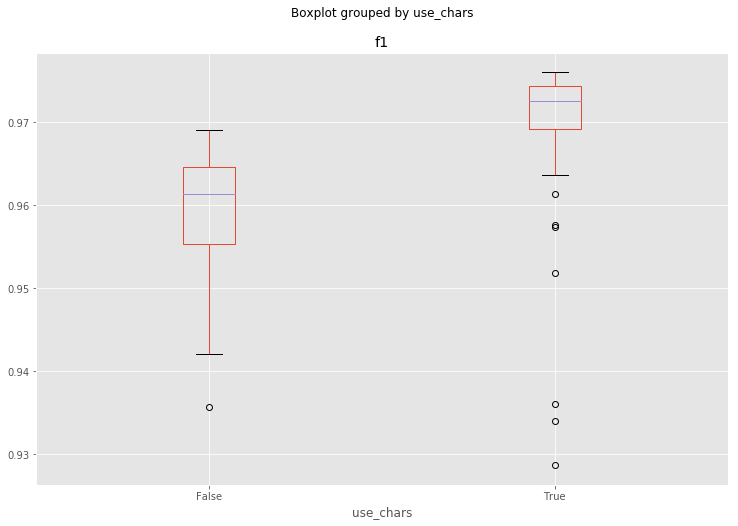

In [63]:
df_lstm.boxplot(column='f1', by='use_chars', figsize=(12, 8))

It seems `use_chars=True` is significantly better than `False`.

#### Multinomial variables

##### filter_width

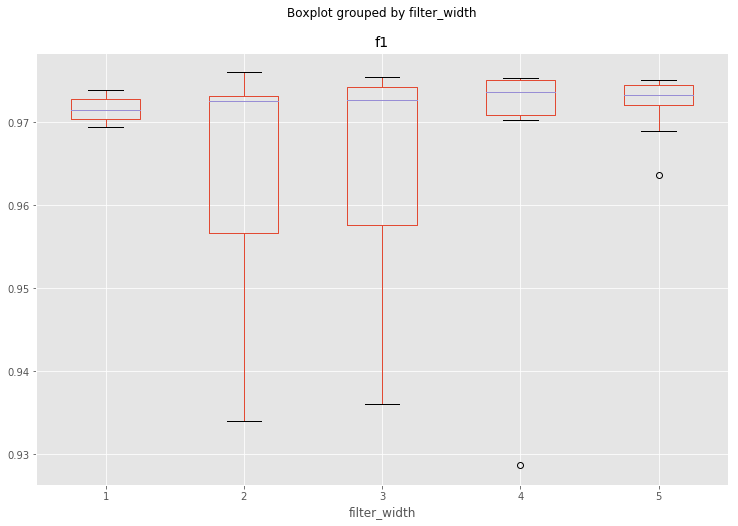

In [64]:
df_lstm[df_lstm.use_chars].boxplot(column='f1', by='filter_width', figsize=(12, 8))

It seems all width works equally well, although for width of 2 and 3, the F1 score sometimes can be lower than 0.96. Another surprising finding that does not align with our intuition.

#### Continuous variables

##### lr

In [65]:
df_lstm2 = df_lstm.copy()
df_lstm2['log10_lr'] = np.log10(df_lstm2.lr)

In [66]:
df_lstm2.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window,log10_lr
5,0.304057,0.960915,5,0.019847,2676,752276329,False,False,True,False,False,0,-1.702298
7,0.082773,0.968059,3,0.007260,2678,811399240,False,False,True,True,True,0,-2.139071
10,0.116364,0.965639,3,0.009684,2681,799135189,False,False,True,False,True,0,-2.013935
11,0.349528,0.967218,4,0.014770,2682,857452985,False,False,True,True,True,0,-1.830630
12,0.173727,0.959045,3,0.001144,2683,819392958,False,False,True,False,False,0,-2.941499


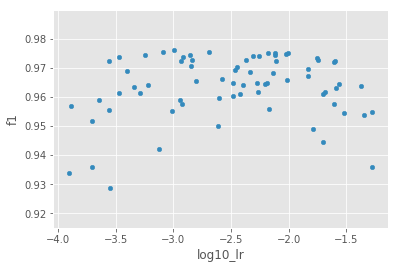

In [67]:
df_lstm2.plot.scatter(x='log10_lr', y='f1')

It seems the best range for `log10_lr` is around -2.5 and -2.

##### dropout

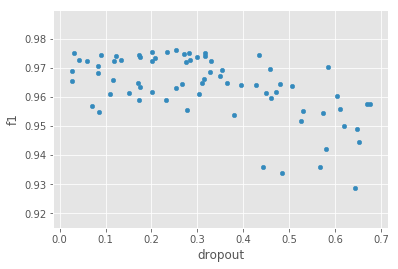

In [68]:
df_lstm.plot.scatter(x='dropout', y='f1')

It seems the best range for `dropout` is between 0 and 0.4.

#### Conclusion

- Prefixes are not significant
- Suffixes are significant only when characters are not used
- Characters are significant
- All filter width values are equally good, although width of 2 and 3 can achieve significantly lower score sometimes
- Best range for the power of learning rate is -2.5 and -2
- Best range for dropout is 0 to 0.4

### LSTM + CRF

In [69]:
df_lstm_crf = df[(df.use_lstm) & (df.use_crf)]
len(df_lstm_crf)

60

In [70]:
df_lstm_crf.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window
19,0.235024,0.962237,4,0.006790,2690,781994409,False,True,True,False,False,0
23,0.038882,0.957793,1,0.046885,2694,786525377,False,True,True,False,False,0
25,0.524174,0.956736,4,0.016753,2696,166688225,False,True,True,False,False,0
27,0.490529,0.962259,3,0.013497,2698,540186964,False,True,True,False,True,0
29,0.184974,0.967649,2,0.000706,2700,763545544,False,True,True,True,True,0


#### Binary variables

##### use_prefix

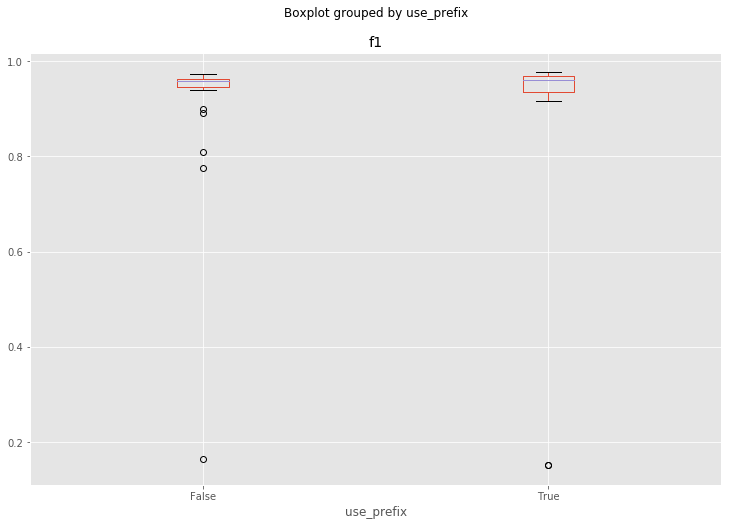

In [71]:
df_lstm_crf.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

Let's remove the outliers for good.

In [72]:
df_lstm_crf = df_lstm_crf[df_lstm_crf.f1 > 0.9]

In [73]:
len(df_lstm_crf)

53

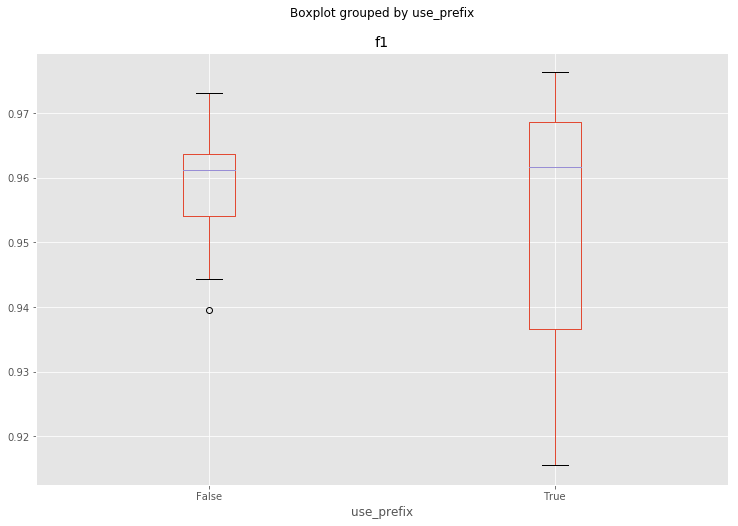

In [74]:
df_lstm_crf.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [75]:
ttest_ind(df_lstm_crf[df_lstm_crf.use_prefix]['f1'], df_lstm_crf[~df_lstm_crf.use_prefix]['f1'])

Ttest_indResult(statistic=-1.081041485123039, pvalue=0.28476416656325537)

The p-value is large, so we accept the null hypothesis. Let's see when characters are not used.

In [76]:
len(df_lstm_crf[~df_lstm_crf.use_chars])

32

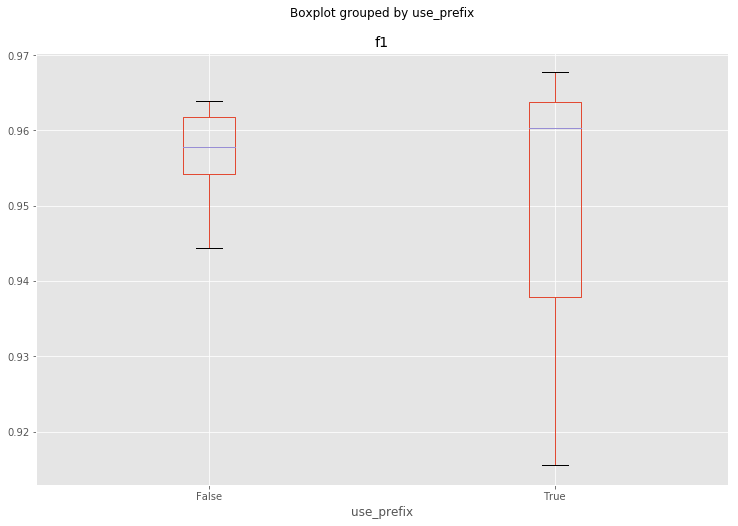

In [77]:
df_lstm_crf[~df_lstm_crf.use_chars].boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [78]:
ttest_ind(df_lstm_crf[(~df_lstm_crf.use_chars) & (df_lstm_crf.use_prefix)]['f1'],
          df_lstm_crf[(~df_lstm_crf.use_chars) & (~df_lstm_crf.use_prefix)]['f1'])

Ttest_indResult(statistic=-1.2780859034012706, pvalue=0.21102004039886552)

The p-value is still large, so we accept the null hypothesis.

##### use_suffix

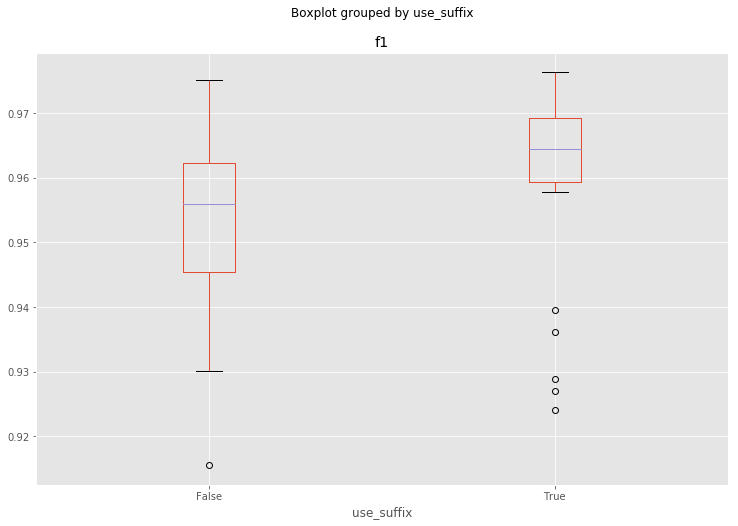

In [79]:
df_lstm_crf.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [80]:
ttest_ind(df_lstm_crf[df_lstm_crf.use_suffix]['f1'], df_lstm_crf[~df_lstm_crf.use_suffix]['f1'])

Ttest_indResult(statistic=1.5331947240684682, pvalue=0.13140841024594854)

The p-value is large, so we accept the null hypothesis. Let's see when character features are not used.

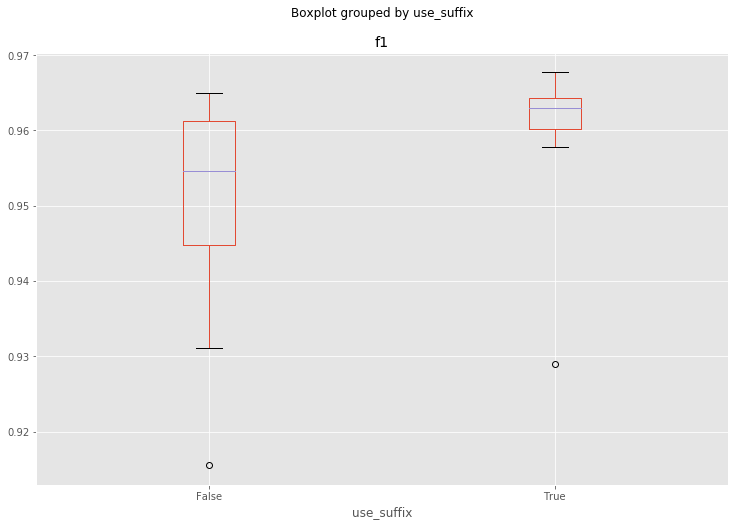

In [81]:
df_lstm_crf[~df_lstm_crf.use_chars].boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [82]:
ttest_ind(df_lstm_crf[(~df_lstm_crf.use_chars) & (df_lstm_crf.use_suffix)]['f1'],
          df_lstm_crf[(~df_lstm_crf.use_chars) & (~df_lstm_crf.use_suffix)]['f1'])

Ttest_indResult(statistic=1.7900051549250553, pvalue=0.08355201933787905)

The p-value is large, so again we accept the null hypothesis.

##### use_chars

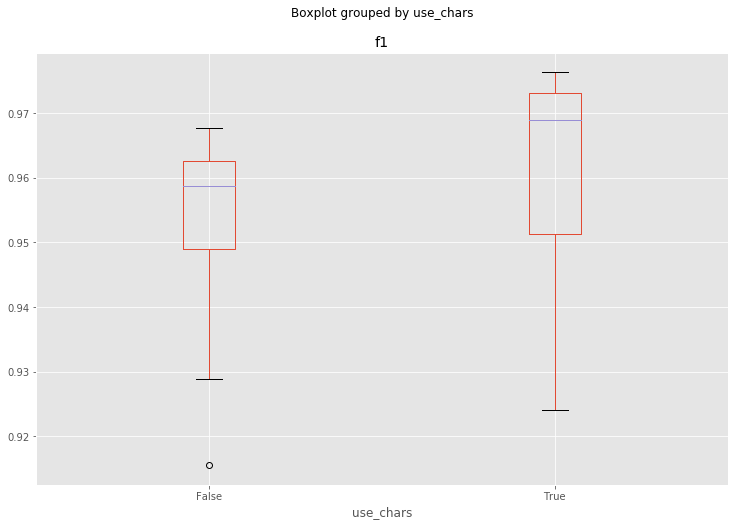

In [83]:
df_lstm_crf.boxplot(column='f1', by='use_chars', figsize=(12, 8))

In [84]:
ttest_ind(df_lstm_crf[df_lstm_crf.use_chars]['f1'], df_lstm_crf[~df_lstm_crf.use_chars]['f1'])

Ttest_indResult(statistic=1.4403620998635718, pvalue=0.1558760956949545)

The p-value is large. Accept null hypothesis. So it seems character features are not so useful anymore in this case.

#### Multinomial variables

##### filter_width

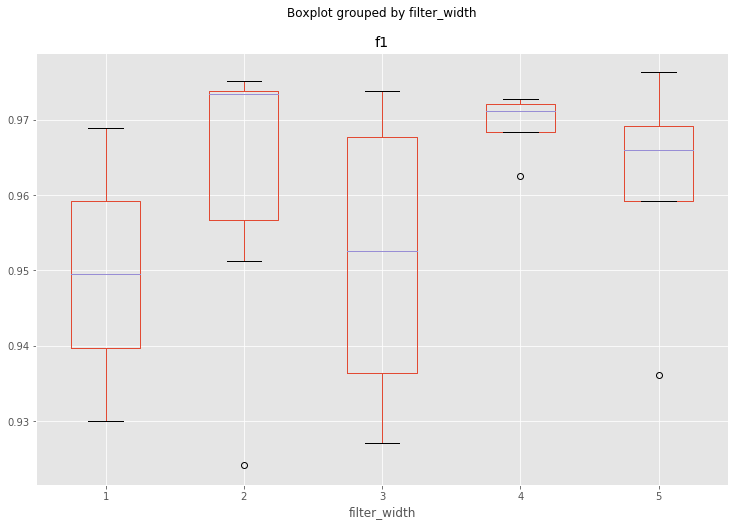

In [85]:
df_lstm_crf[df_lstm_crf.use_chars].boxplot(column='f1', by='filter_width', figsize=(12, 8))

It seems the best value for `filter_width` is 2 or 4. Surprisingly, from the plot we see that width of 3 has a bad performance.

#### Continuous variables

##### lr

In [86]:
df_lstm_crf2 = df_lstm_crf.copy()
df_lstm_crf2['log10_lr'] = np.log10(df_lstm_crf2.lr)

In [87]:
df_lstm_crf2.head()

,dropout,f1,filter_width,lr,run_id,seed,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window,log10_lr
19,0.235024,0.962237,4,0.006790,2690,781994409,False,True,True,False,False,0,-2.168103
23,0.038882,0.957793,1,0.046885,2694,786525377,False,True,True,False,False,0,-1.328963
25,0.524174,0.956736,4,0.016753,2696,166688225,False,True,True,False,False,0,-1.775919
27,0.490529,0.962259,3,0.013497,2698,540186964,False,True,True,False,True,0,-1.869759
29,0.184974,0.967649,2,0.000706,2700,763545544,False,True,True,True,True,0,-3.151045


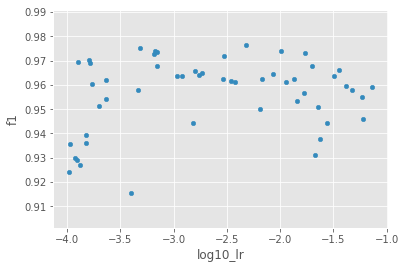

In [88]:
df_lstm_crf2.plot.scatter(x='log10_lr', y='f1')

The best range for `lr` seems to be between -3 and -2.

##### dropout

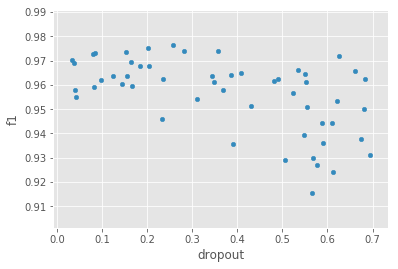

In [89]:
df_lstm_crf.plot.scatter(x='dropout', y='f1')

The best range for dropout seems to be between 0 and 0.2.

#### Conclusion

- Prefixes are not significant
- Suffixes are not significant
- Characters are not significant
- Best filter width values are 2 or 4
- Best range for the power of learning rate is -3 to -2
- Best range for dropout is 0 to 0.2